In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.animation as anm
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams['animation.html'] = 'html5'

import sys
import time

In [2]:
# Time step progress bar
def update_progress_bar(current, total):
    sys.stdout.write('\rTime step: [{:<50}] {:.0f}/{:.0f} ({:.2f}%)'.format('=' * int(current/total * 50), current, total, current*100/total))
    sys.stdout.flush()

Reynolds number = 20.0

Minimum required time step: 0.005202913631633714s
Selected time step = 0.0025974025974025974s
Total number of time steps = 385

Stability Criteria 1 (0.25: dimensionless): True (0.12480519480519482)
Stability Criteria 2 (4: dimensionless): True (0.10389610389610389)

Computational domain:


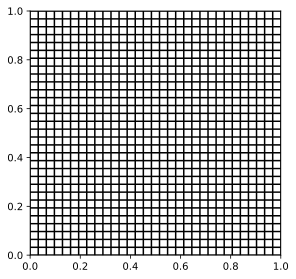

In [3]:
ut = 1 # Top wall velocity
tf = 1 # Total time of simulation.
ν = 0.05 # Kinematic viscosity of fluid
ρ = 1 # Density of fluid

nx = 32 # Grid points along x
ny = 32 # Grid points along y
Lx = 1 # Length of domain along x
Ly = 1 # Length of domain along y
dx = Lx/(nx - 1)
dy = Ly/(ny - 1)

print(f'Reynolds number = {ut*Lx/ν}')
print(f'\nMinimum required time step: {min(0.25*dx*dx/ν, (4*ν)/(ut*ut))}s')
dt = min(0.25*(min(dx, dy)**2)/ν, (4*ν)/(ut*ut))/2
ts = math.ceil(tf/dt)
dt = tf/ts
print(f'Selected time step = {dt}s\nTotal number of time steps = {ts}')
print(f'\nStability Criteria 1 (0.25: dimensionless): {(ν*dt)/(min(dx, dy)**2) < 0.25} ({(ν*dt)/(min(dx, dy)**2)})')
print(f'Stability Criteria 2 (4: dimensionless): {(ut*ut*dt)/ν < 4} ({(2*ut*ut*dt)/ν})')


# Plot computational domain
print('\nComputational domain:')
xs, ys = np.meshgrid(np.linspace(0, Lx, nx), np.linspace(0, Ly, ny))
pw = 4.5
fig, ax = plt.subplots(figsize = (pw, (pw*Ly)/Lx))
ax.plot(xs, ys, c = 'k')
ax.plot(np.transpose(xs), np.transpose(ys), c = 'k')
ax.set(xlim = [0, Lx], ylim = [0, Ly])
plt.show()

In [4]:
# Initialise velocities and pressure as zeroes
u_0 = np.zeros([ny, nx])
v_0 = np.zeros([ny, nx])
p_0 = np.zeros([ny, nx])

u_0[-1, :] = ut

In [5]:
ϵ = 1e-3 # Convergence tolerance
max_itr = 100 # Maximum number of inner iterations for psi in each time step
Ap = 0.5/(dx*dx + dy*dy)

# Empty lists for u, v, p to store solutions at each time step
p_sol, u_sol, v_sol = [], [], []
u_sol.append(u_0)
v_sol.append(v_0)
p_sol.append(p_0)

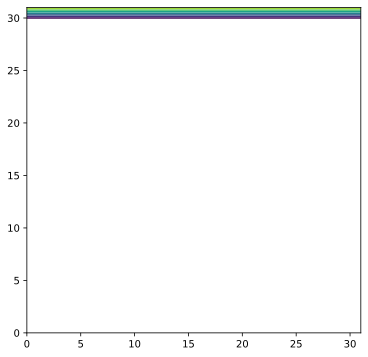

In [6]:
# Plotting initial contour
plt.figure(figsize = (6,6))
plt.contour(u_sol[0])

In [7]:
def d_dx_cds(f, dx):
    return (f[1:-1, 2:] - f[1:-1, :-2])/(2*dx)
    
def d_dy_cds(f, dy):
    return (f[2:, 1:-1] - f[:-2, 1:-1])/(2*dy)

def laplacian(f, dx, dy):
    return (f[1:-1, 2:] - 2*f[1:-1, 1:-1] + f[1:-1, :-2])/(dx*dx) + (f[2:, 1:-1] - 2*f[1:-1, 1:-1] + f[:-2, 1:-1])/(dy*dy)

def div(a1, a2, dx, dy):
    return d_dx_cds(a1, dx) + d_dy_cds(a2, dy)

In [8]:
start = time.time()
t = 0
while t < tf:
    
    u_n = u_sol[-1]
    v_n = v_sol[-1]
    u_n1 = u_sol[-1].copy()
    v_n1 = v_sol[-1].copy()
    u_p = u_sol[-1].copy()
    v_p = v_sol[-1].copy()
        
    # Advective term for x and y NS
    Ax = d_dx_cds(u_n*u_n, dx) + d_dy_cds(u_n*v_n, dy)
    Ay = d_dx_cds(u_n*v_n, dx) + d_dy_cds(v_n*v_n, dy)
    
    # Diffusion term for x and y NS
    Dx = laplacian(u_n, dx, dy)
    Dy = laplacian(v_n, dx, dy)
    
    # Predictor step
    rhs_x = ν*Dx - Ax
    rhs_y = ν*Dy - Ay
    u_p[1:-1, 1:-1] = u_n[1:-1, 1:-1] + dt*rhs_x
    v_p[1:-1, 1:-1] = v_n[1:-1, 1:-1] + dt*rhs_y
    
    # Solving the PPE
    ppe_rhs = np.zeros([ny, nx])
    ppe_rhs[1:-1, 1:-1] = div(u_p, v_p, dx, dy)*ρ/dt

    itr = 0
    err = 100
    p_k1 = p_sol[-1].copy()
    while err > ϵ and itr < max_itr:
        p_k = p_k1.copy()
        for i in range(1, nx - 1):
            for j in range(1, ny - 1):
                p_k1[j, i] = Ap*((p_k1[j, i+1]+p_k1[j, i-1])*dy*dy + (p_k1[j+1, i]+p_k1[j-1, i])*dx*dx - ppe_rhs[j, i]*ρ*(dx*dy)**2)
        p_k1[:, 0] = p_k1[:, 1] # Left wall
        p_k1[:, -1] = p_k1[:, -2] # Right wall
        p_k1[0, :] = p_k1[1, :] # Bottom wall
        p_k1[-1, :] = 0 # Top wall
        err = np.linalg.norm(p_k1 - p_k, 2)
        itr+=1
    p_sol.append(p_k1)
    
    # Corrector step
    u_n1[1:-1, 1:-1] = u_p[1:-1, 1:-1] - (dt/ρ)*d_dx_cds(p_k1, dx)
    v_n1[1:-1, 1:-1] = v_p[1:-1, 1:-1] - (dt/ρ)*d_dy_cds(p_k1, dy)
    
    u_sol.append(u_n1)
    v_sol.append(v_n1)
    
    time.sleep(dt)
    t+=dt
    progress = t / tf  # Calculate progress as a percentage
    update_progress_bar(int(t/dt), ts)

update_progress_bar(ts, ts)
end = time.time() - start
print(f'\nTime taken for simulation: {round(end, 3)}s')

Time step: [==================================================] 385/385 (100.00%)
Time taken for simulation: 11.158s


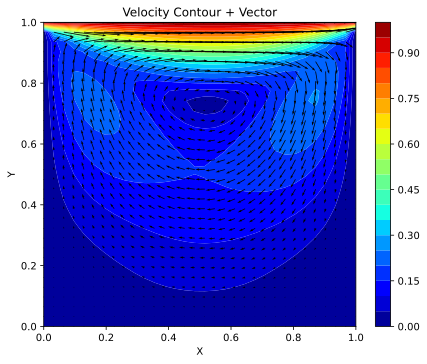

In [9]:
# Vector
frame = -1
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x, y)

width = 7
fig, ax = plt.subplots(figsize = (width, (Ly/Lx)*width*0.8))
cont = ax.contourf(X, Y, np.sqrt(u_sol[-1]**2 + v_sol[-1]**2), cmap = plt.cm.jet, levels = 20)
ax.quiver(X, Y, u_sol[frame], v_sol[frame], scale=5)
plt.colorbar(cont, ax=ax)
ax.set(xlabel = 'X', ylabel = 'Y', title = 'Velocity Contour + Vector', xlim = [X[0, 0], X[0, -1]], ylim = [Y[0, 0], Y[-1, 0]])
plt.show()

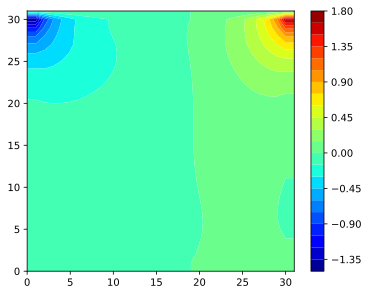

In [10]:
# Pressure contour
width = 6
plt.figure(figsize = (width, (Ly/Lx)*width*0.8))
plt.contourf(p_sol[-1], cmap = plt.cm.jet, levels = 20)
plt.colorbar()
plt.show()

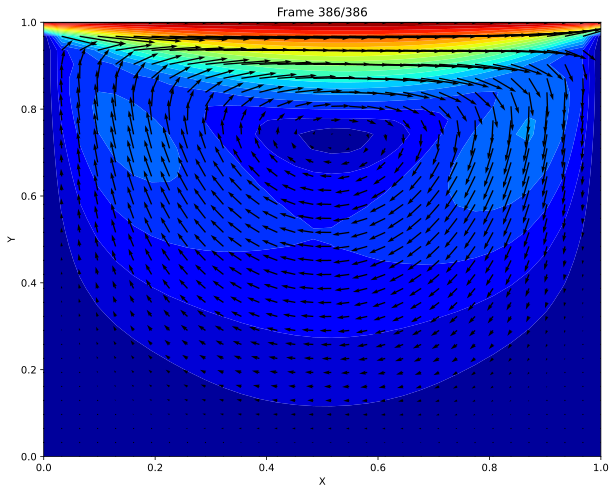

In [11]:
# Vector animation
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
X, Y = np.meshgrid(x, y)
width = 10
fig, ax = plt.subplots(figsize = (width, (Ly/Lx)*width*0.8))
def update(frame):
    ax.clear()  # Clear the previous plot
    ax.contourf(X, Y, np.sqrt(u_sol[frame]**2 + v_sol[frame]**2), cmap = plt.cm.jet, levels = 20)
    ax.quiver(X, Y, u_sol[frame], v_sol[frame], scale=5)
    ax.set(xlabel = 'X', ylabel = 'Y', title = f'Frame {frame + 1}/{len(u_sol)}', xlim = [X[0, 0], X[0, -1]], ylim = [Y[0, 0], Y[-1, 0]])

animation = anm.FuncAnimation(fig, update, frames=list(range(0, len(u_sol), int(len(u_sol)/100)))+[len(u_sol)-1], repeat=False)
animation

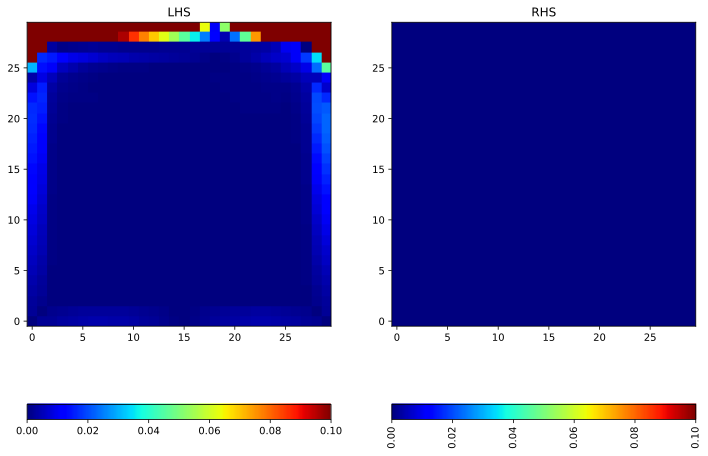

In [14]:
# Check mass conservation (through continuity)
div_u = div(u_sol[-1], v_sol[-1], dx, dy)
div_rhs = div(u_p, v_p, dx, dy) - (dt/ρ)*laplacian(p_sol[-1], dx, dy)

# Plot
width = 12
fig, ax = plt.subplots(figsize = (width, (Ly/Lx)*width*0.8), ncols = 2)
cont1 = ax[0].imshow(abs(div_u), cmap = plt.cm.jet, origin = 'lower', vmin = 0, vmax = 0.1)
cont2 = ax[1].imshow(abs(div_rhs), cmap = plt.cm.jet, origin = 'lower', vmin = 0, vmax = 0.1)
plt.colorbar(cont1, ax=ax[0], orientation = 'horizontal')
cbar2 = plt.colorbar(cont2, ax=ax[1], orientation = 'horizontal')
cbar2.ax.xaxis.set_tick_params(rotation = 90)
ax[0].set(title = 'LHS')
ax[1].set(title = 'RHS')
plt.show()

In case the above image is not visible:

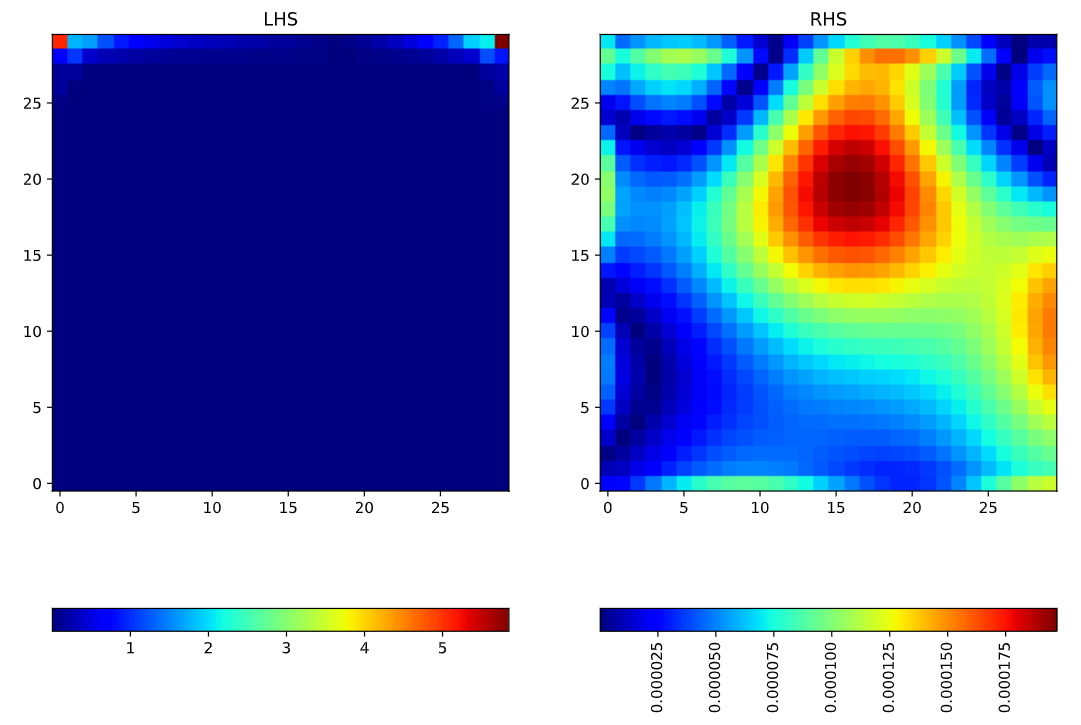

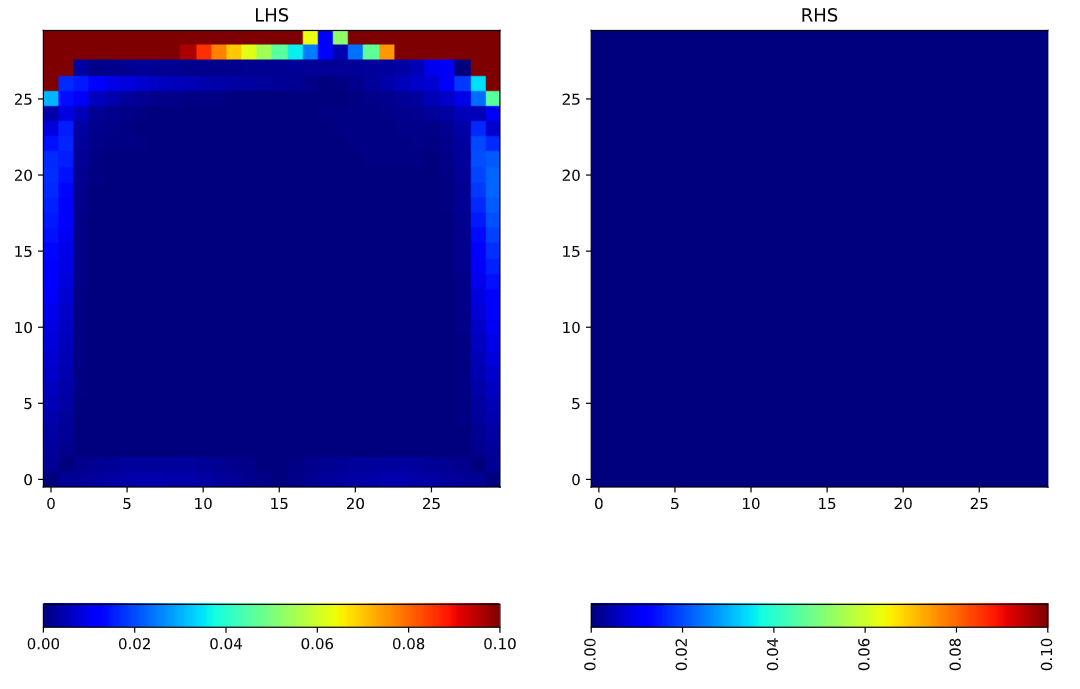